In [2]:
from salad.serialize import read, write
from salad.analysis.plot import plot_cluster, plot_result, plot_fake, plot_catalog
import astropy.table
import os
from functools import lru_cache
import matplotlib.pyplot as plt

from salad.serialize import read
from pathlib import Path
from functools import lru_cache
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.table
import astropy.units as u

In [8]:
def load_results(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}.pkl"))[0])


def recoveries(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}_recovery.pkl"))[0])

def was_found(fake_recovery, threshold=15, vmin=0.1, vmax=0.5):
    ret = []
    for o in fake_recovery:
        f = fake_recovery[o]
        found_points = False
        found_line = False
        n_points = 0
        n_lines = 0
        for c in f['points']:
            p = f['points'][c]
            precision = p['fake']/p['total']
            recall = p['fake']/f['catalog']['fake']
            if precision > 0.5:
                found_points = True
                n_points += 1
                
            if c in f['line']:
                l = f['line'][c]
                line_recovery = l['fake']/l['total']
                if precision > 0.5 and line_recovery > 0.5:
                    found_line = True
                    n_lines += 1
        
        v = ((f['info']['vra']**2 + f['info']['vdec']**2)**0.5)
        if hasattr(v, "unit"):
            v = v.value
        ret.append(
            {
                "orbit": o,
                "found_points": found_points,
                "found_line": found_line,
                "points": f['catalog']['fake'],
                "n_points": n_points,
                "n_lines": n_lines,
                "fake_detection": f['catalog']['fake'],
                "fake_injection": f['catalog']['total'],
                "filtered": (v < vmin) | (v > vmax)
            }
        )
        
        if 'findable' in f['info']:
            ret[-1]['in_search'] = f['info']['findable']
        elif f['catalog']['total'] == 1:
            ret[-1]['in_search'] = False
            
            
    return astropy.table.Table(ret)

def wilson_score_interval(z_alpha, n_s, n_f):
    n = n_s + n_f
    m = (n_s + 0.5 * z_alpha**2) / (n + z_alpha**2)
    u = ((z_alpha) / (n + z_alpha**2)) *  ((n_s*n_f/n) + (z_alpha**2)/4)**0.5
    return m - u, m + u

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            l, u = wilson_score_interval(1, num_recovered, num_possible - num_recovered)
            errors.append([num_recovered/num_possible - l, u - num_recovered/num_possible])
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, np.array(errors).T

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as autograd_np

def p(m, c, k, m_50):
    return c / (1 + autograd_np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return autograd_np.log(c) - autograd_np.log(1 + autograd_np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return autograd_np.sum(log_p(recovered_mag, c, k, m_50)) + autograd_np.sum(autograd_np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return (
        autograd_np.sum(autograd_np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        autograd_np.sum(autograd_np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results, mag_col='mag', found_col='found'):
    recovered_mag = results[results[found_col]][mag_col].value
    missed_mag = results[~results[found_col]][mag_col].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = autograd_np.sqrt(autograd_np.diag(autograd_np.linalg.inv(hess)))
        else:
            fit_std = autograd_np.array([autograd_np.nan, autograd_np.nan, autograd_np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d


In [75]:
search_prefix = "new"
detector = 1

f = []
for detector in range(1, 63):
    if detector in [2, 31, 61]:
        continue
    try:
        fakes = read(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/fakes.pkl")
    except:
        print(detector)
    f.append(fakes)
fakes = astropy.table.vstack(f)


mags = []
for g in fakes.group_by("ORBITID").groups:
    mags.append(
        {
            "orbit": g[0]['ORBITID'],
            "mag": np.median(g['MAG'])
        }
    )
mags = astropy.table.Table(mags)

In [76]:
import numpy as np

snrs = [3.0, 3.5, 4.0, 4.5, 5.0]
detectors = [i for i in range(1, 63) if i not in [2, 31, 61]]
fit_data = {}
fit_params = {}
# m_50 = []
# sigma_m_50 = []
# max_mags = []
for snr in snrs:
    fo = []
    for detector in detectors:
        try:
            r = recoveries("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
        found = was_found(r)
        found['detector'] = detector
        fo.append(found)

    found = astropy.table.vstack(fo)
    fo = []
    for g in found.group_by("orbit"):
        g = astropy.table.Table(g)
        if len(g) > 1:
            idx = np.argmax(g[''])
            g['found_points'] = np.logical_or.reduce(g['found_points'])
            g['found_line'] = np.logical_or.reduce(g['found_line'])
            g['in_search'] = np.logical_or.reduce(g['in_search'])
            fo.append(astropy.table.Table(g[0]))
        else:
            fo.append(g)

    found = astropy.table.vstack(fo)
    

    # how do I distinguish t['points'] = 0 meaning not detected vs not included because of masks?

    t = astropy.table.join(found, mags, keys=['orbit'])
    fit_data[snr] = t
#     _t = t[t['in_search'] & (~t['filtered']) & (t['fake_injection'] > 15)]

#     fit_result = do_fit(_t, found_col='found_points')
#     if fit_result:
#         fit_data[snr] = t
#         fit_params[snr] = fit_result



In [77]:
filters = [
    lambda x : np.ones(len(x)).astype(bool),
    lambda x : x['in_search'],
    lambda x : (x['in_search']) & (~x['filtered']),
    lambda x : (x['in_search']) & (~x['filtered']) & (x['fake_injection'] > 15),
]

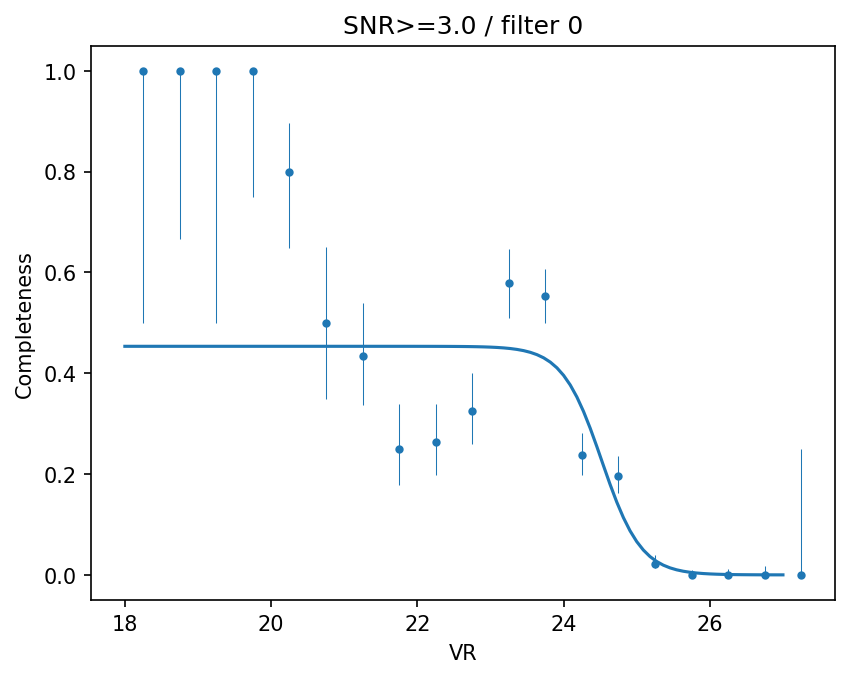

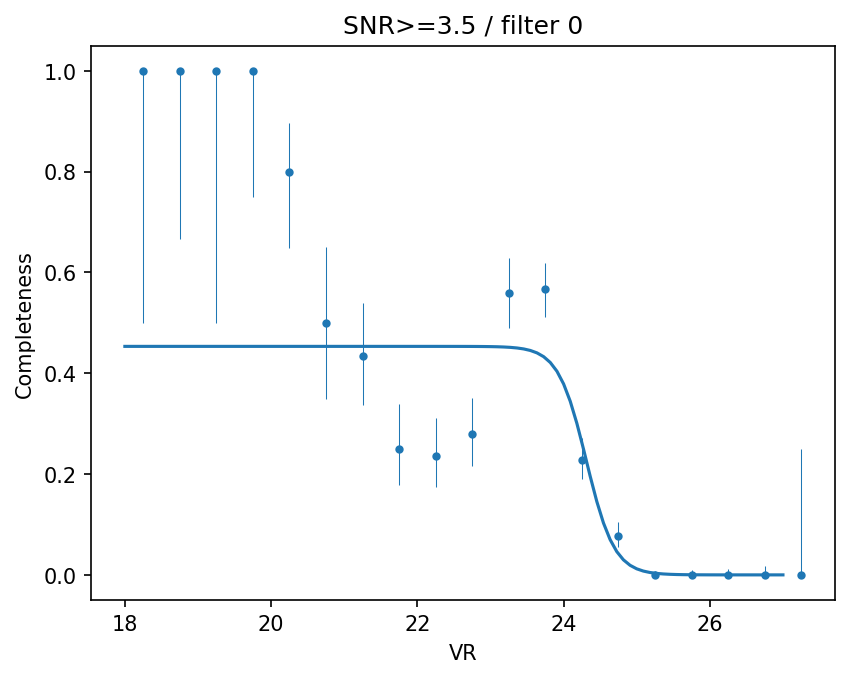

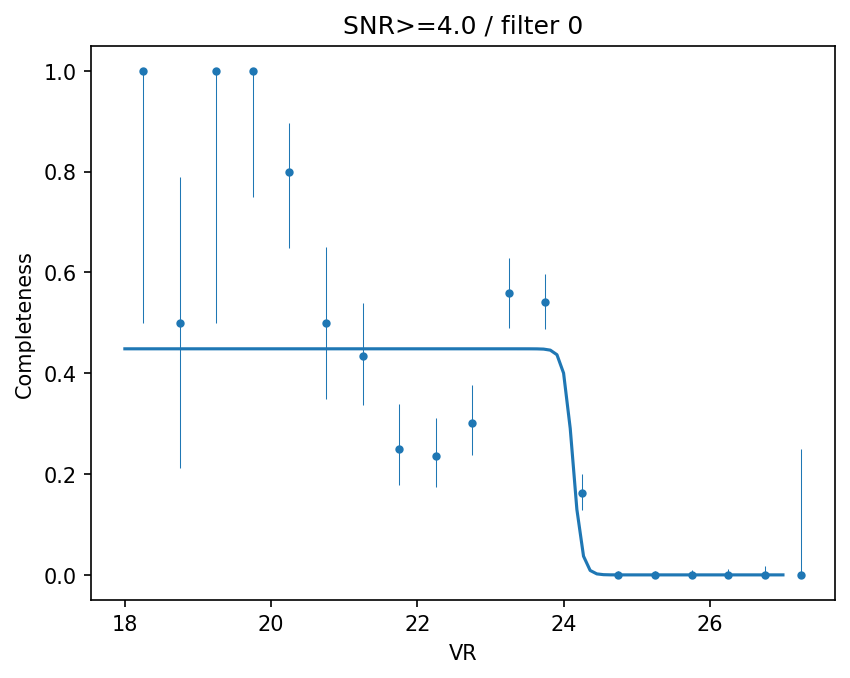

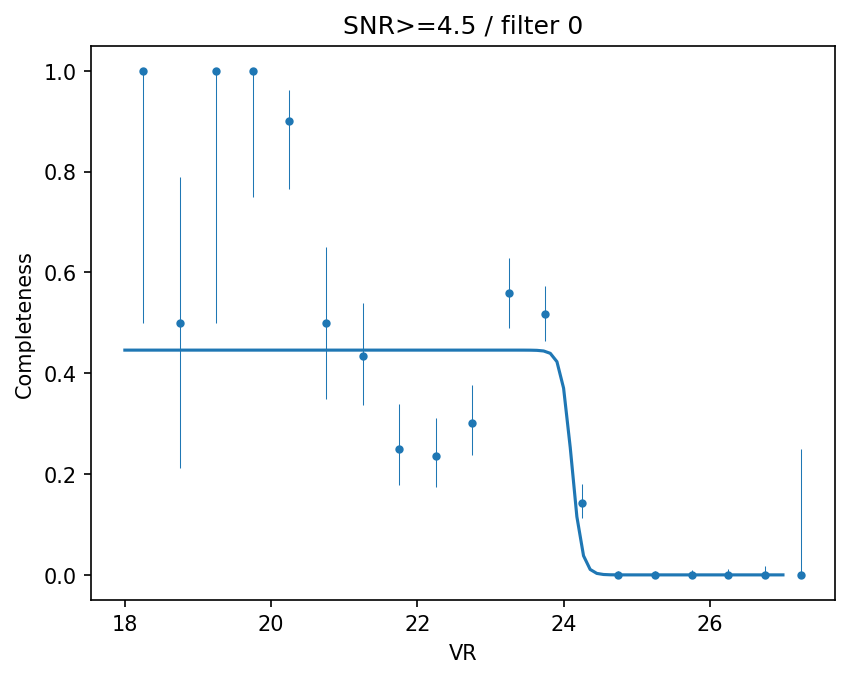

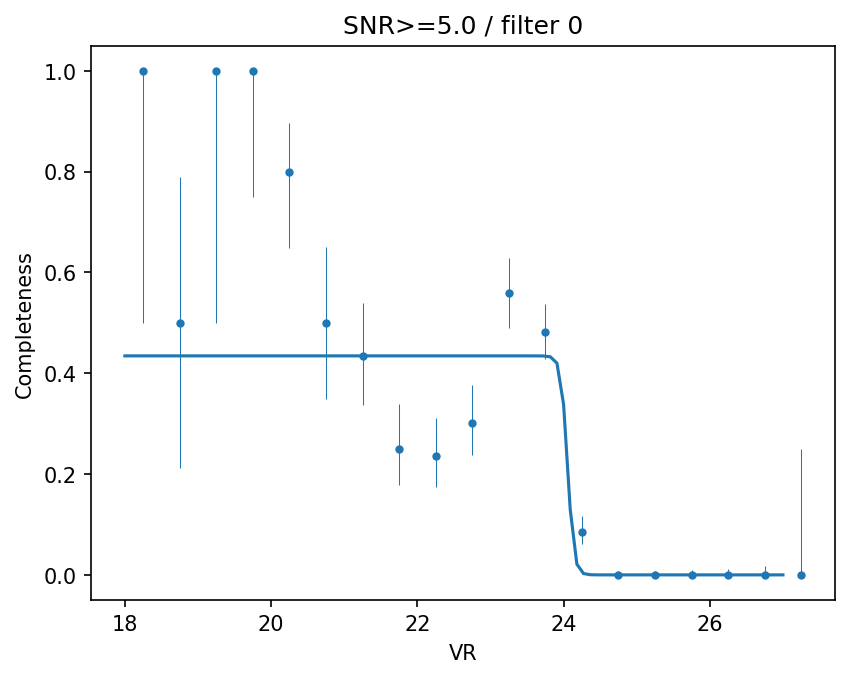

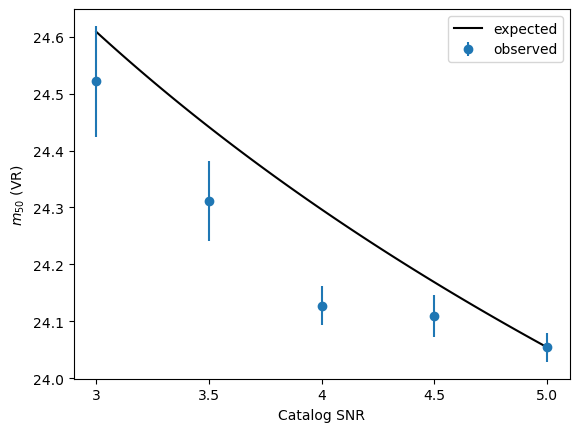

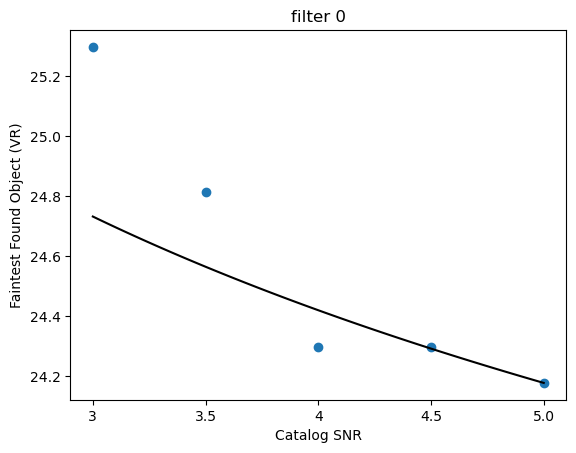

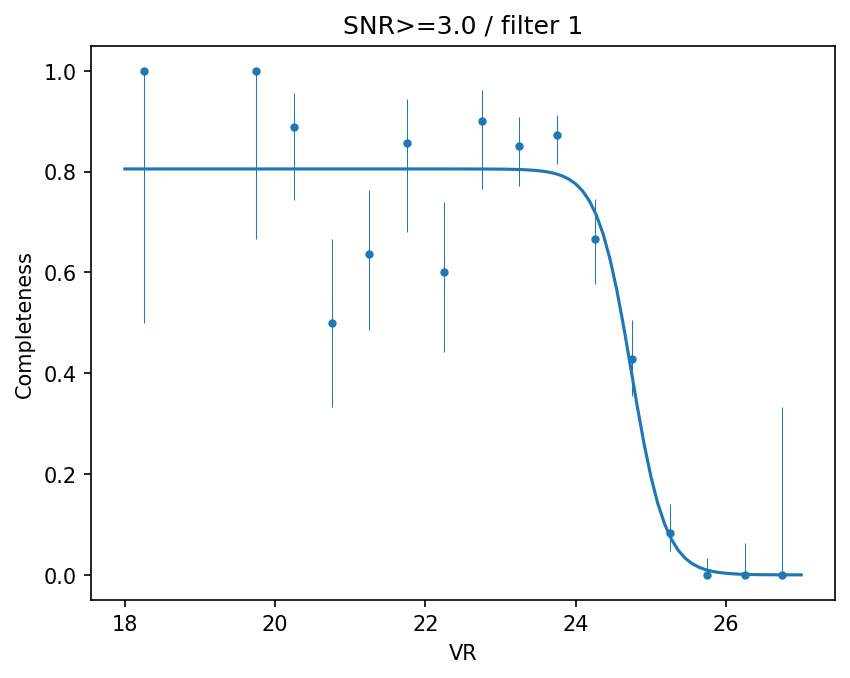

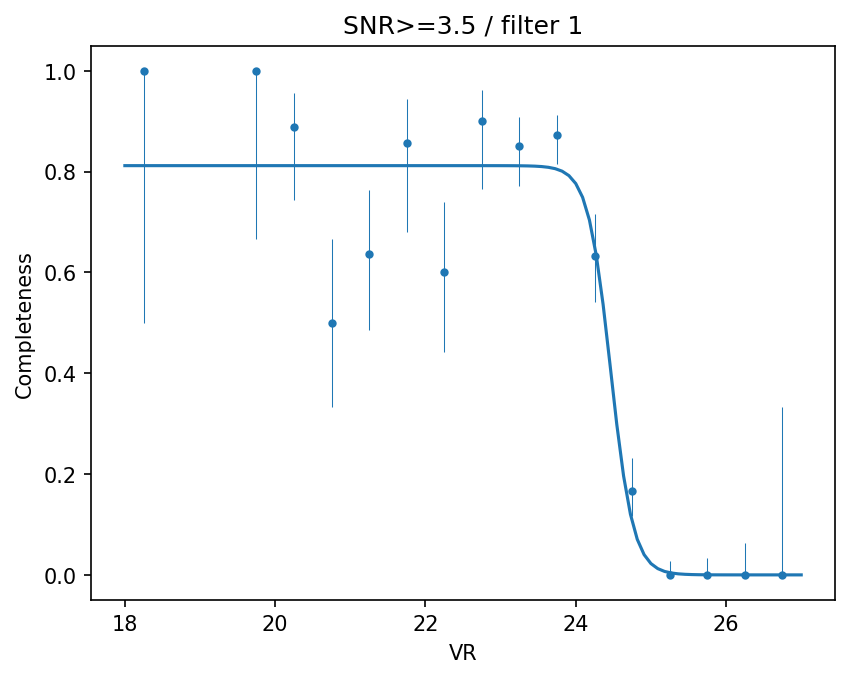

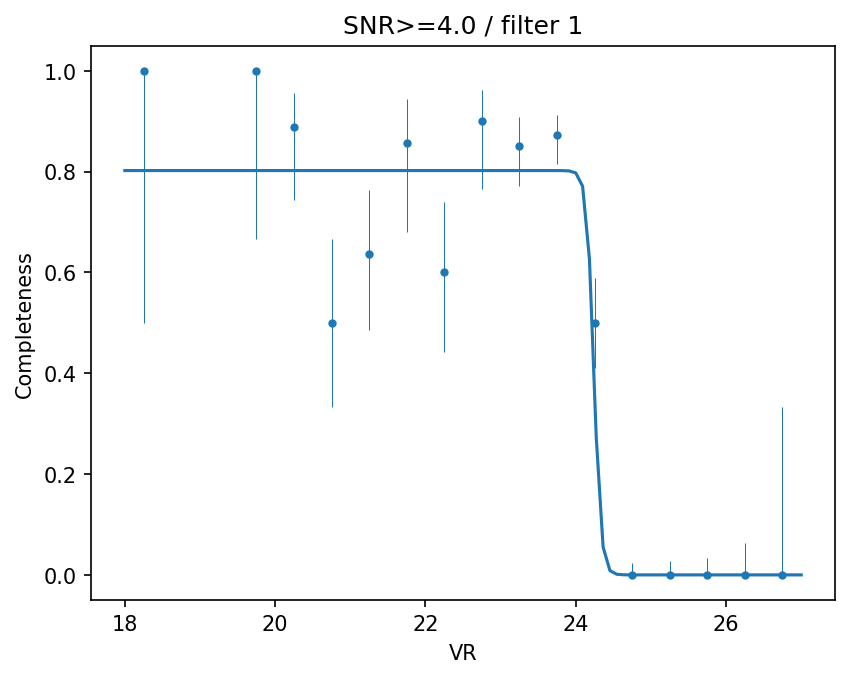

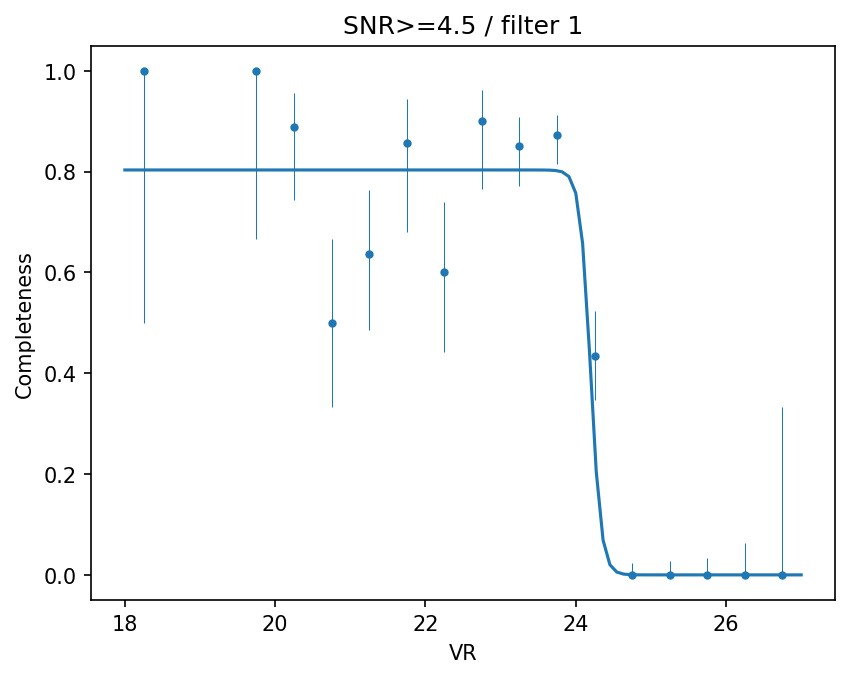

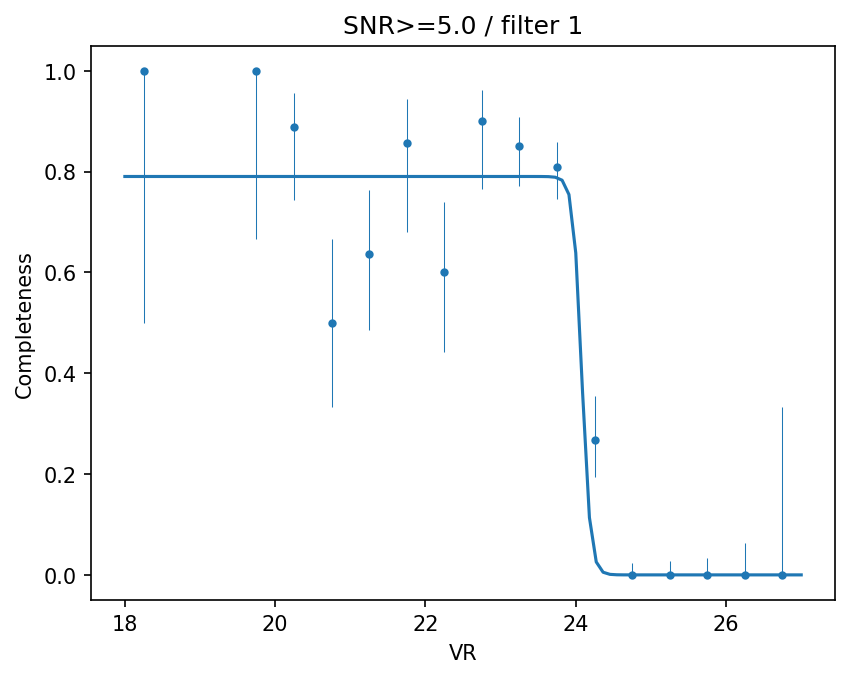

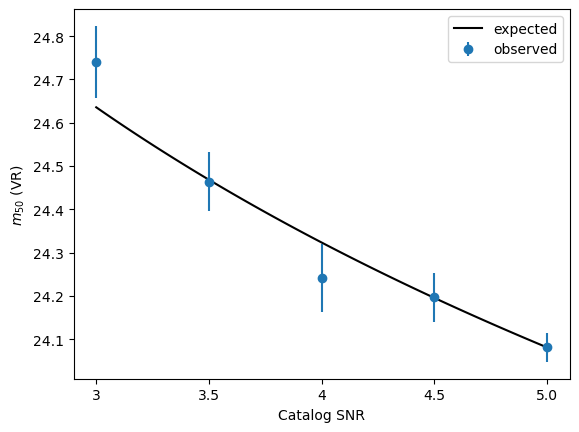

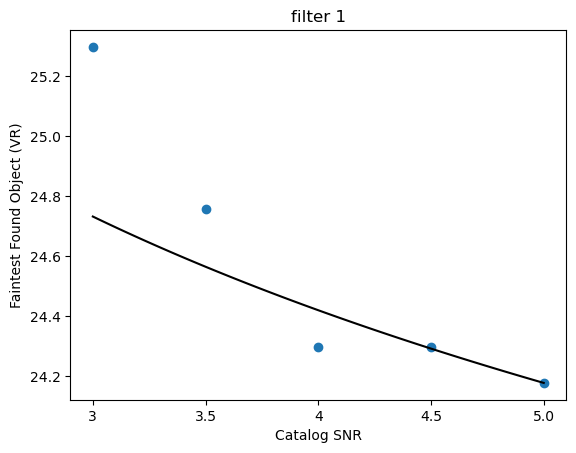

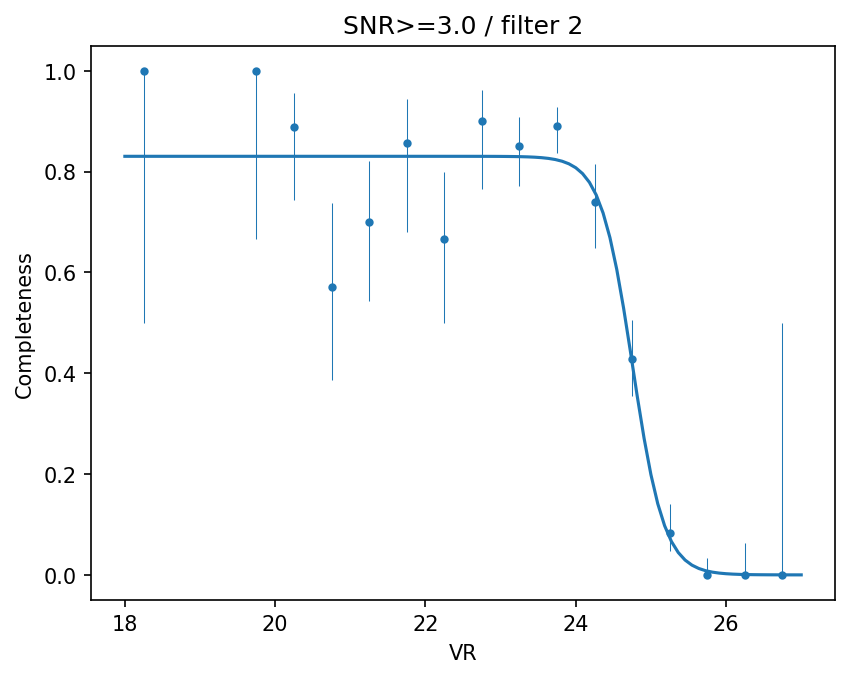

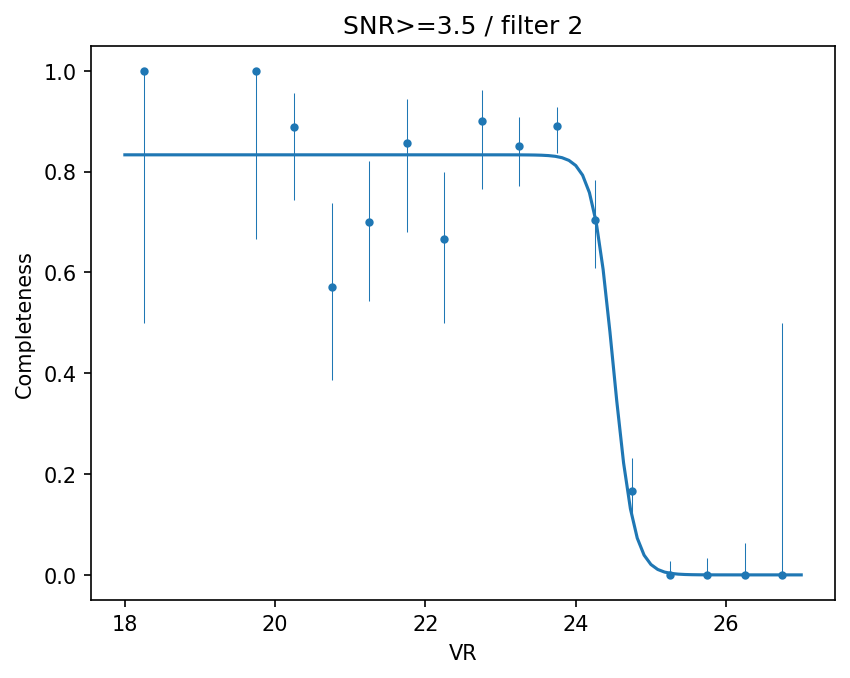

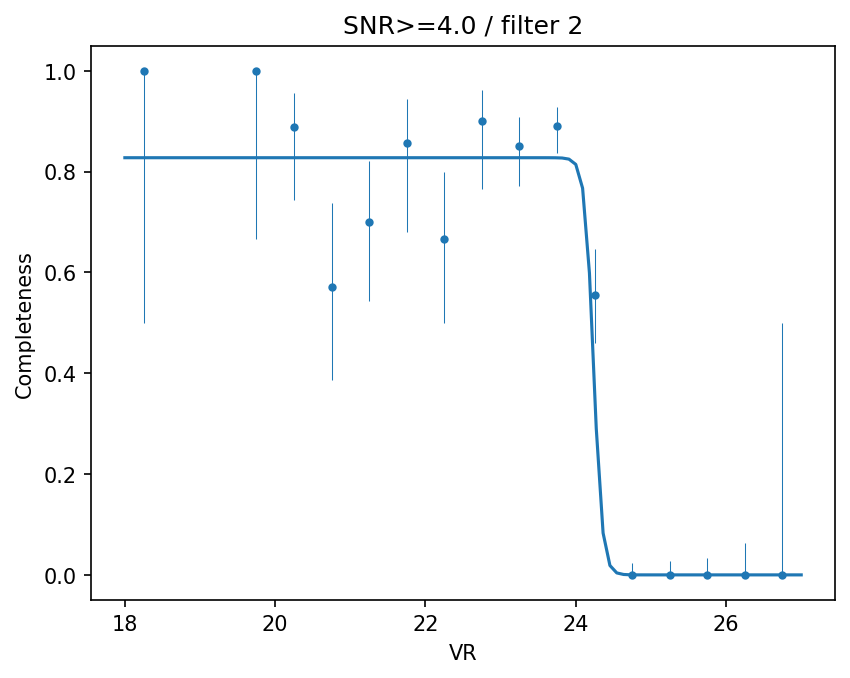

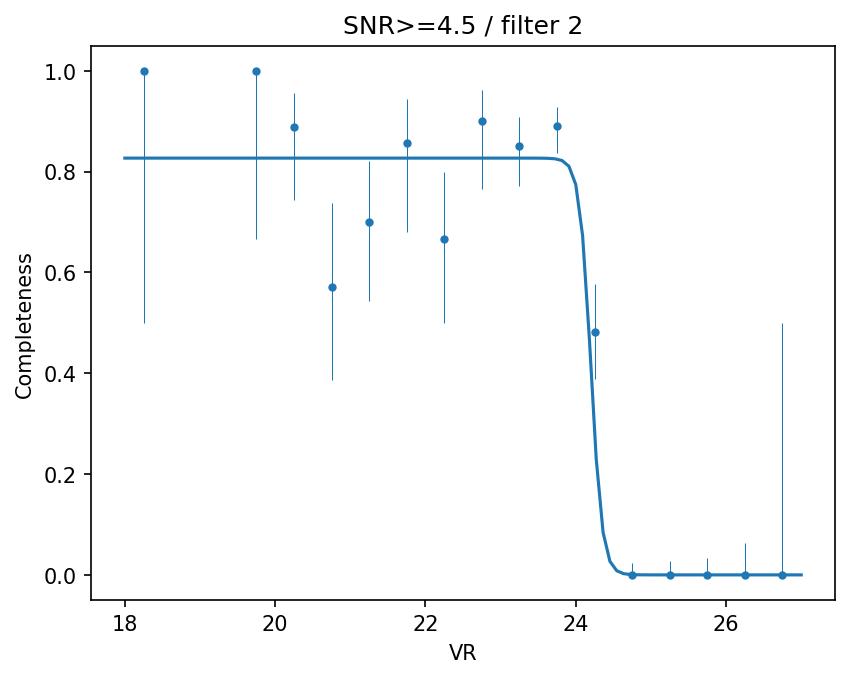

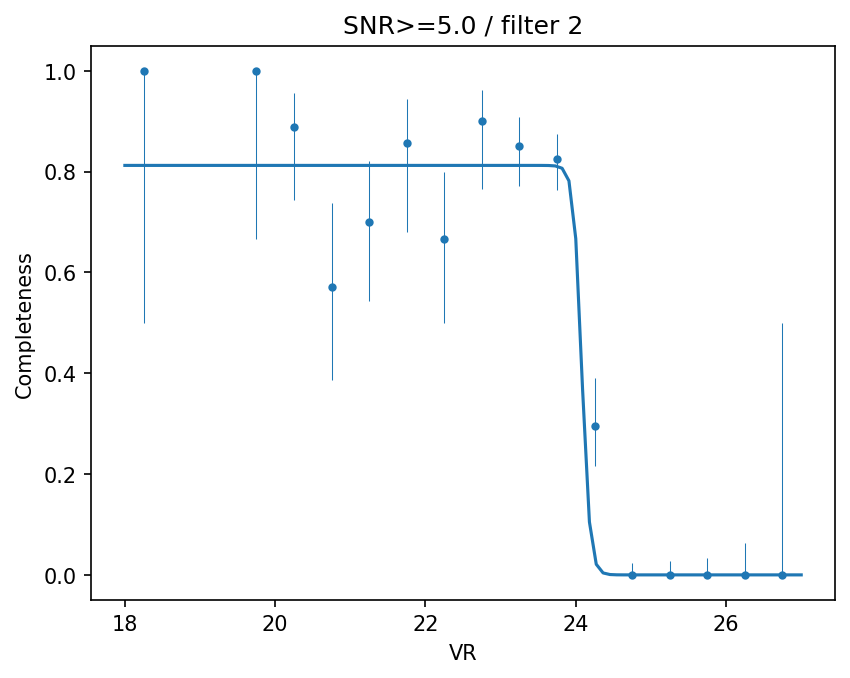

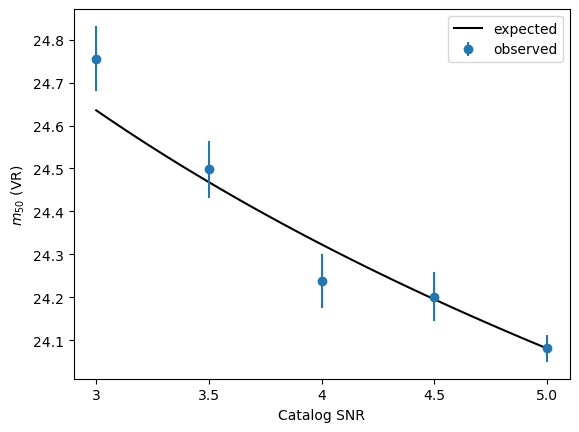

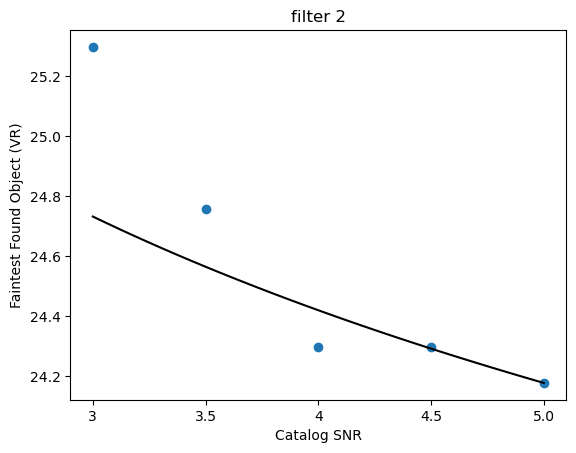

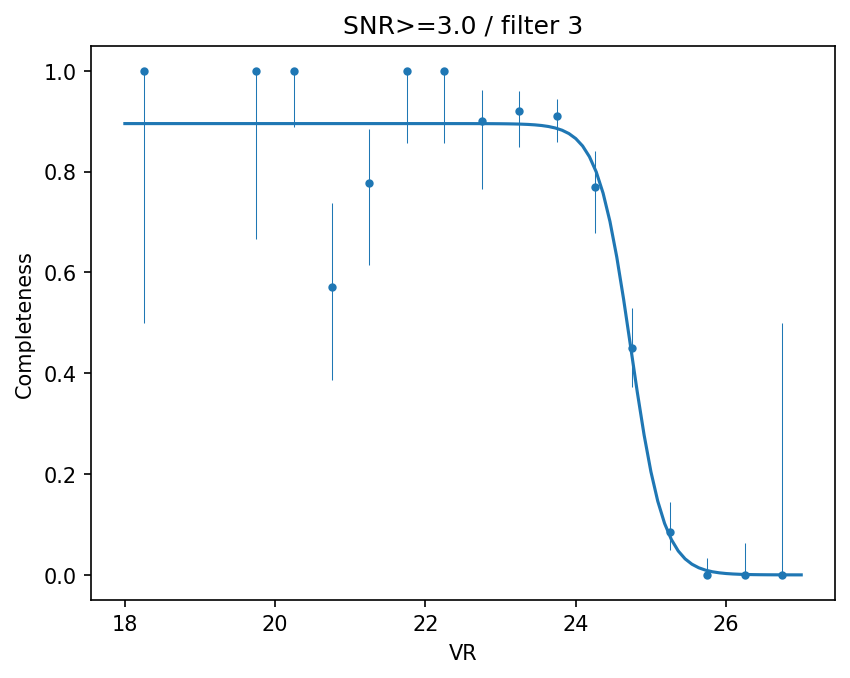

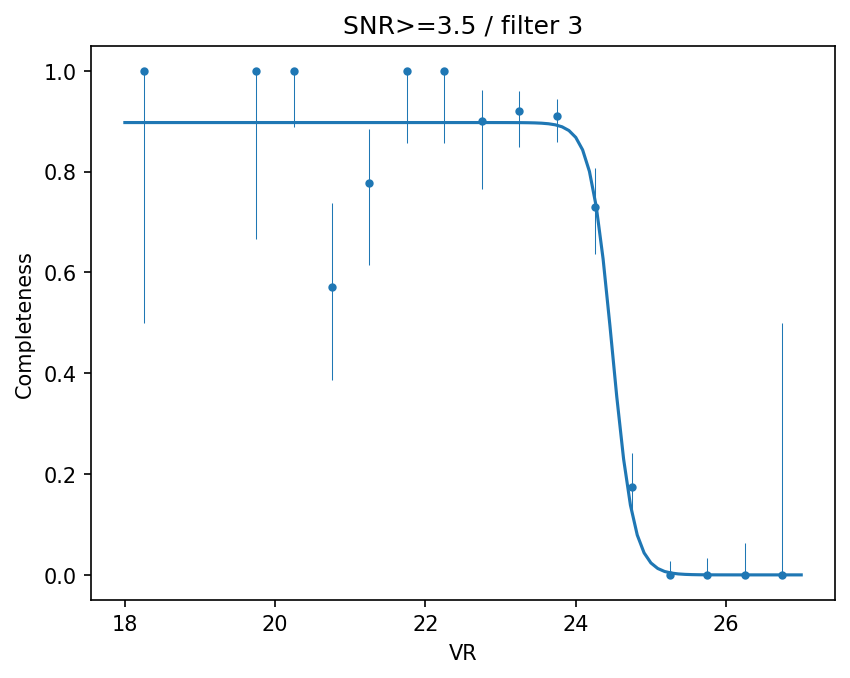

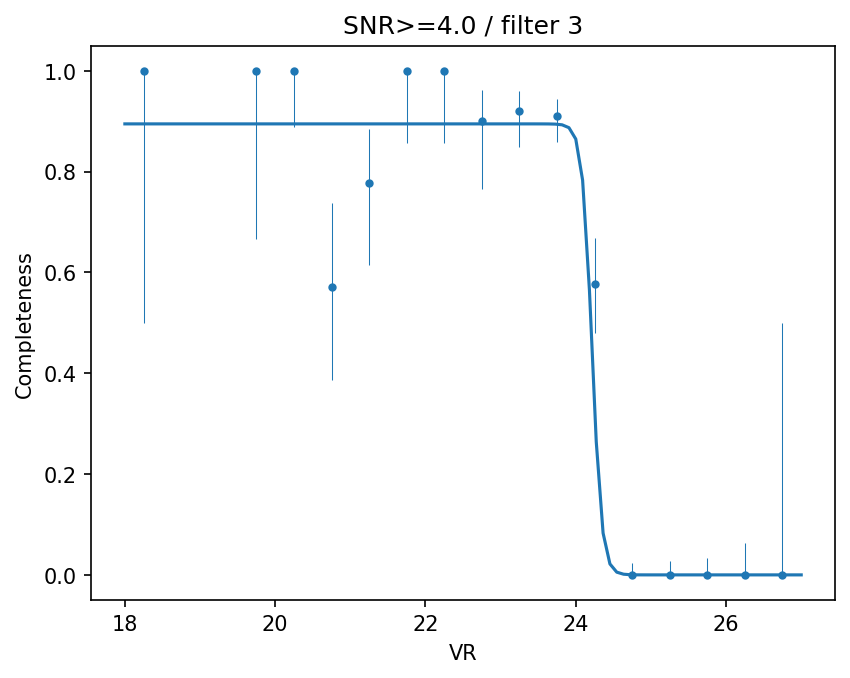

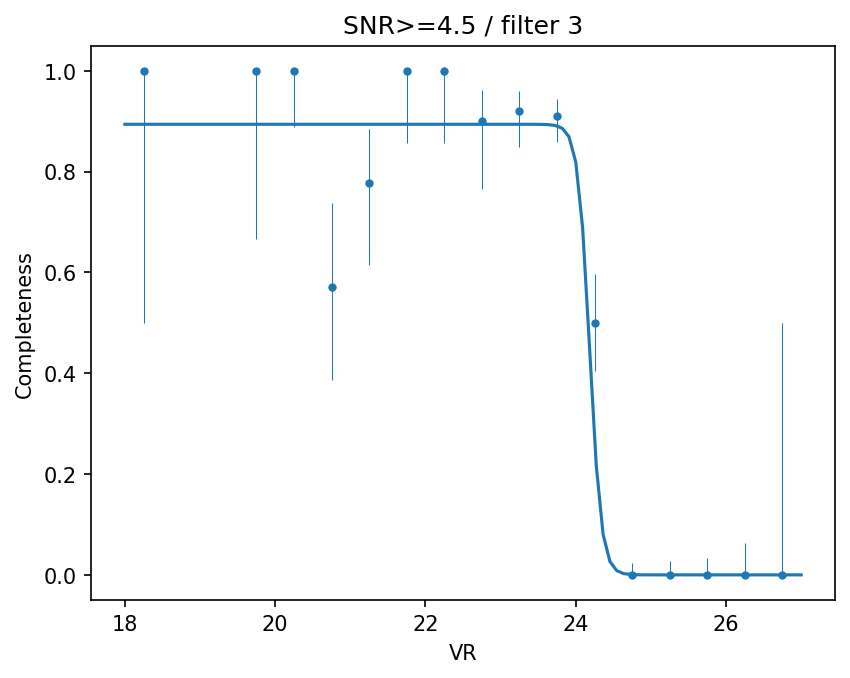

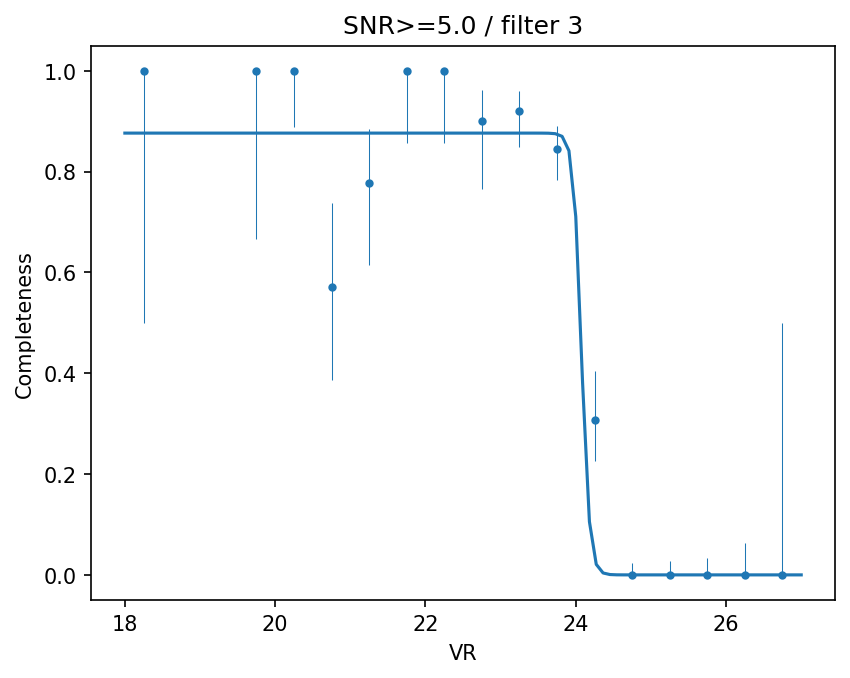

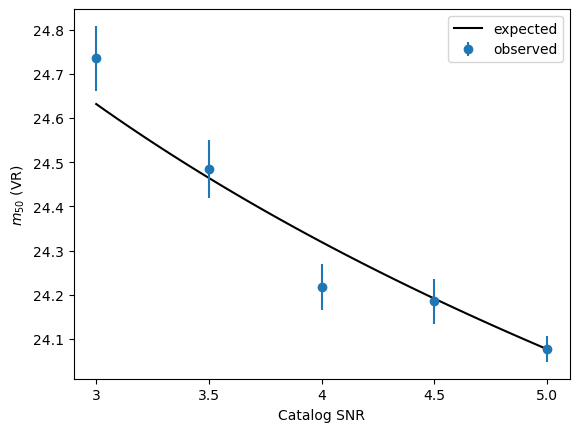

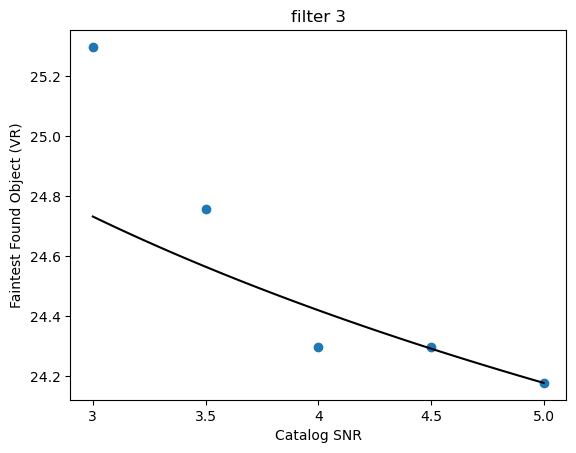

In [87]:
for i, filt in enumerate(filters):
    m_50 = []
    sigma_m_50 = []
    max_mag = []
    for snr in snrs:
        t = fit_data[snr]
        _t = t[filt(t)]

        fit_result = do_fit(_t, found_col='found_points')
        _x = np.linspace(18, 27, 100)
        x, y, yerr = bin_detection(_t, _x.min(), _x.max(), dm=0.5, found_col='found_points')
        _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

        m_50.append(fit_result['m_50'])
        sigma_m_50.append(fit_result['sigma_m_50'])
        max_mag.append(_t[_t['found_points']]['mag'].max())

        plt.figure(dpi=150)
        plt.plot(_x, _y, label=f'SNR>={snr}', color=f'C0')
        plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C0")
        plt.ylabel("Completeness")
        plt.xlabel("VR")
        plt.title(f"SNR>={snr} / filter {i}")
        plt.show()

    x = snrs
    y = m_50
    yerr = sigma_m_50
    _x = np.linspace(min(x), max(x), 100)
    _y = -(5/2) * np.log10(_x / max(x)) + y[x.index(5.0)]
    plt.plot(_x, _y, color='k', label="expected")

    plt.errorbar(snrs, y, yerr=yerr, fmt='o', label='observed')
    plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
    plt.xlabel("Catalog SNR")
    plt.ylabel("$m_{50}$ (VR)")
#     plt.title(f"filter {i}")
    plt.legend()
    plt.show()    
    
    x = snrs
    y = max_mag
    _x = np.linspace(min(x), max(x), 100)
    _y = -(5/2) * np.log10(_x / max(x)) + y[x.index(5.0)]
    plt.plot(_x, _y, color='k', label="expected")

    plt.scatter(snrs, y)
    plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
    plt.xlabel("Catalog SNR")
    plt.ylabel("Faintest Found Object (VR)")
    plt.title(f"filter {i}")
    plt.show()    

In [89]:
m_50[0] - m_50[-1]

0.6578981592642279

In [90]:
m_50

[24.734785477540825,
 24.483860515566263,
 24.21652877494966,
 24.184790896178,
 24.076887318276597]

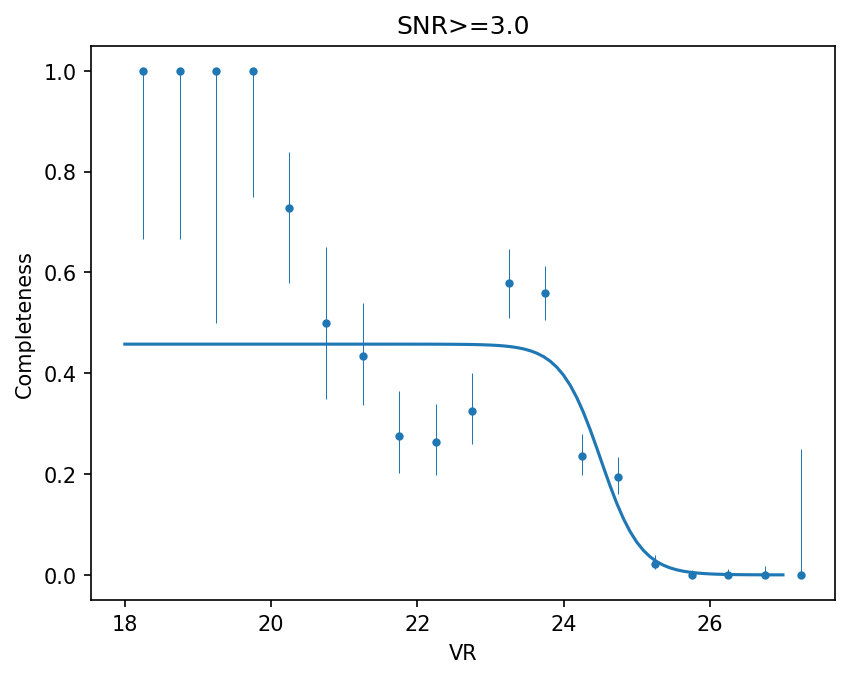

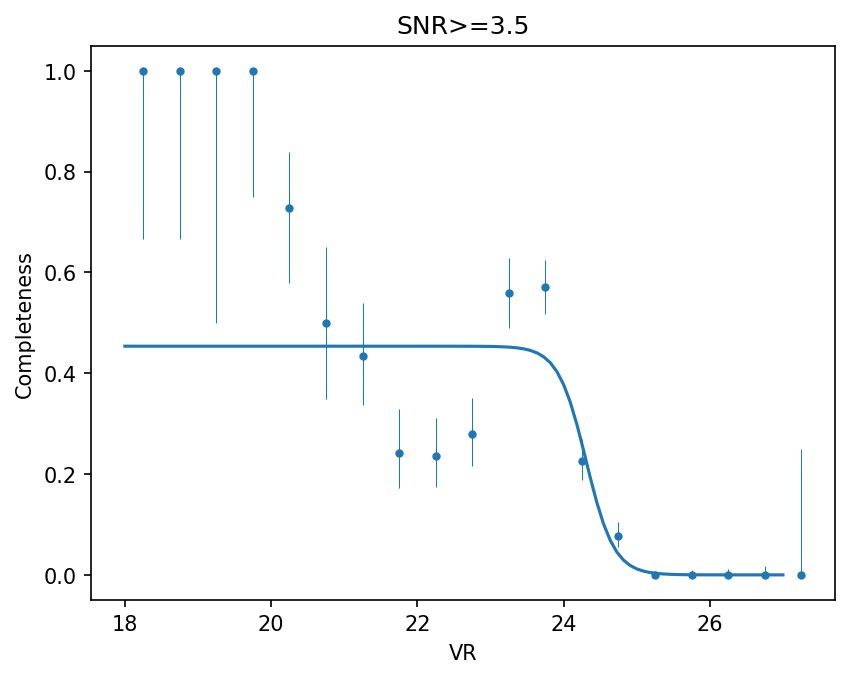

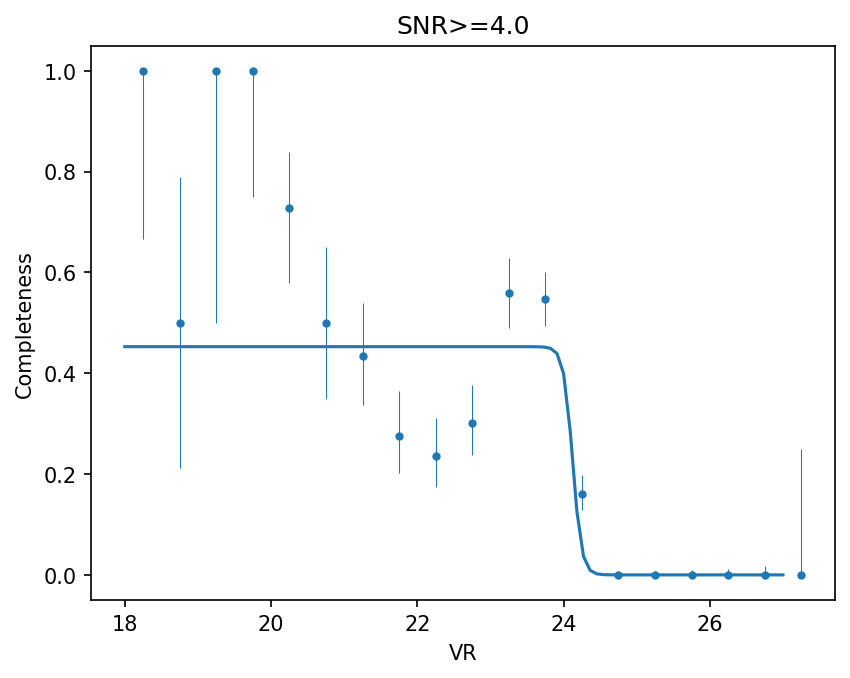

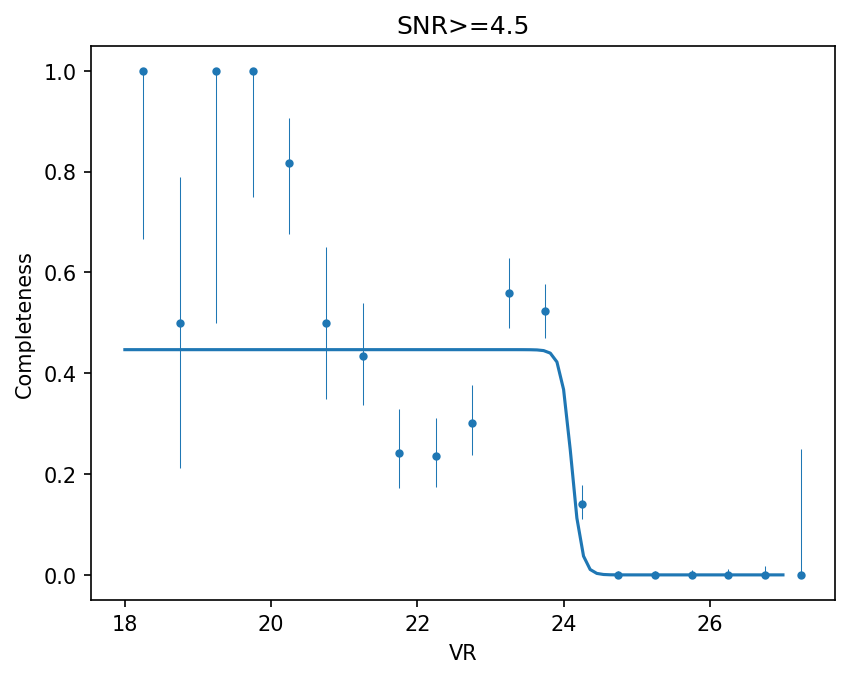

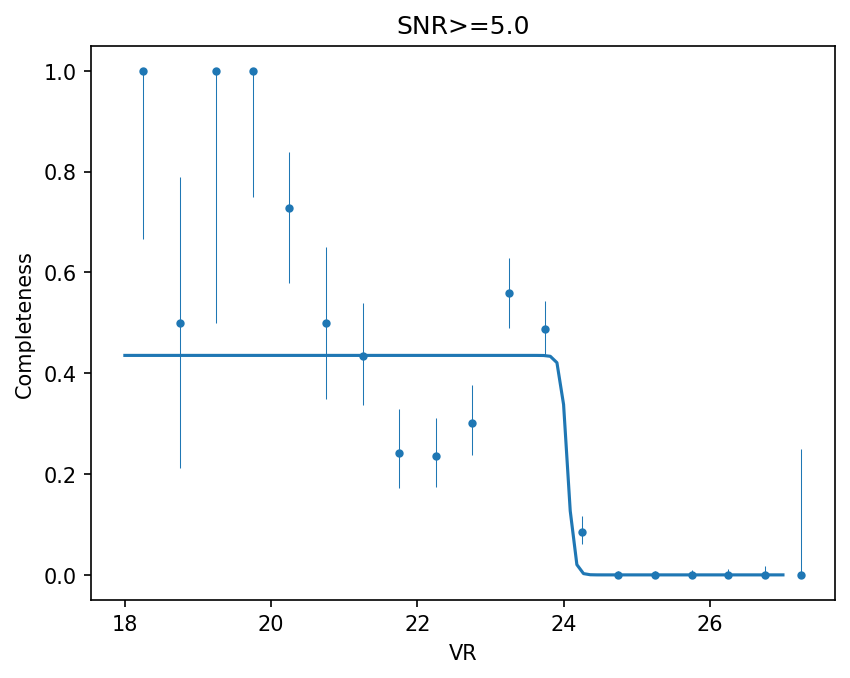

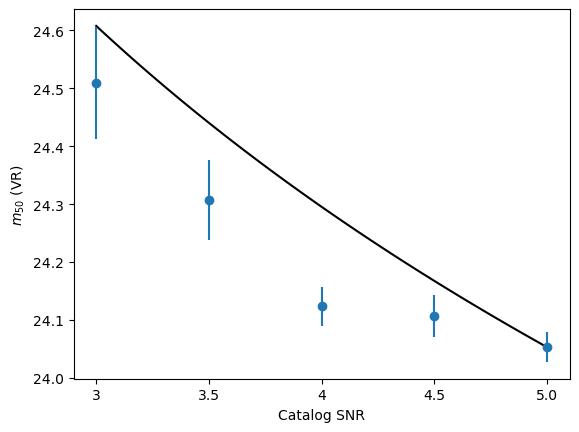

In [40]:
snrs = [3.0, 3.5, 4.0, 4.5, 5.0]


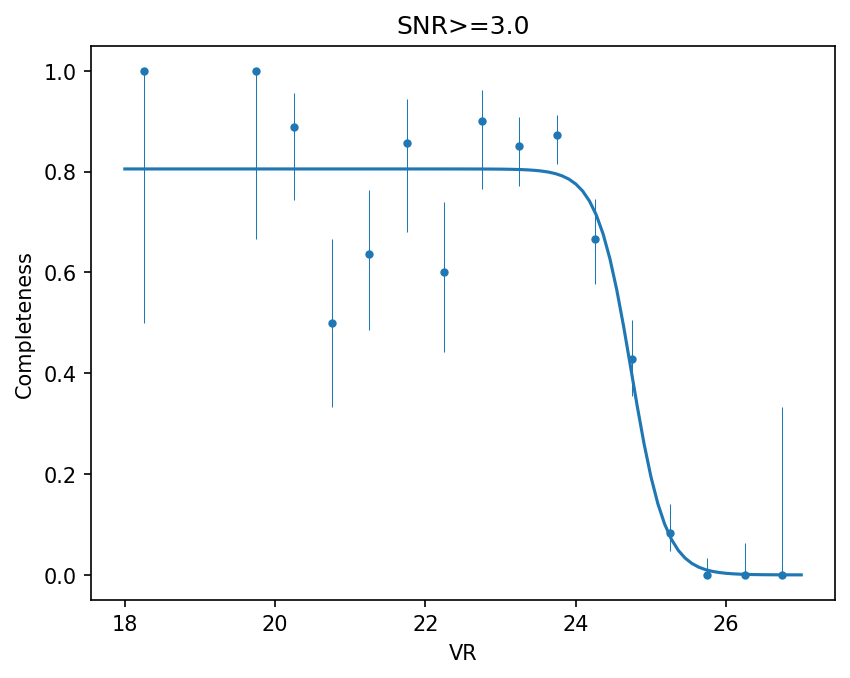

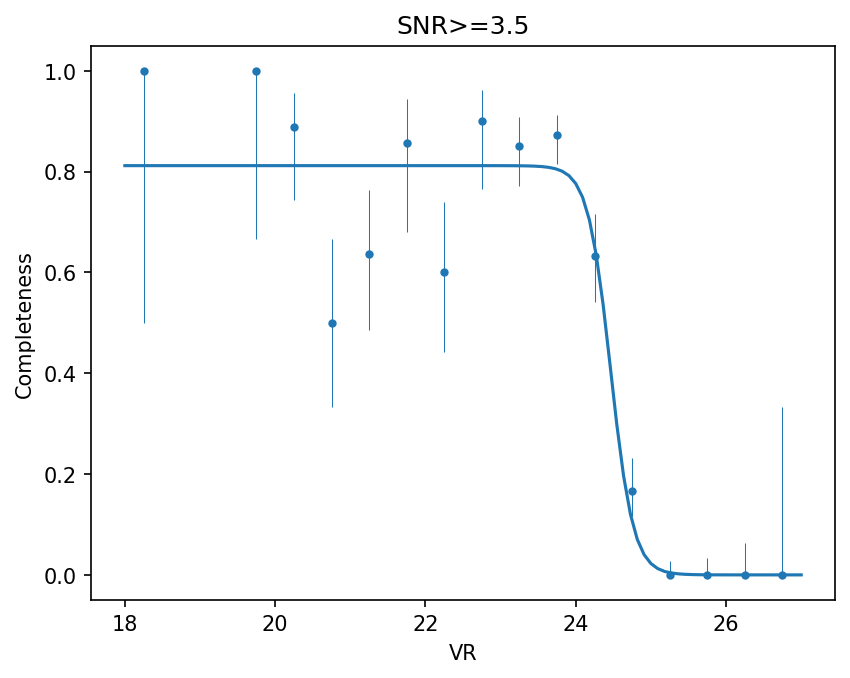

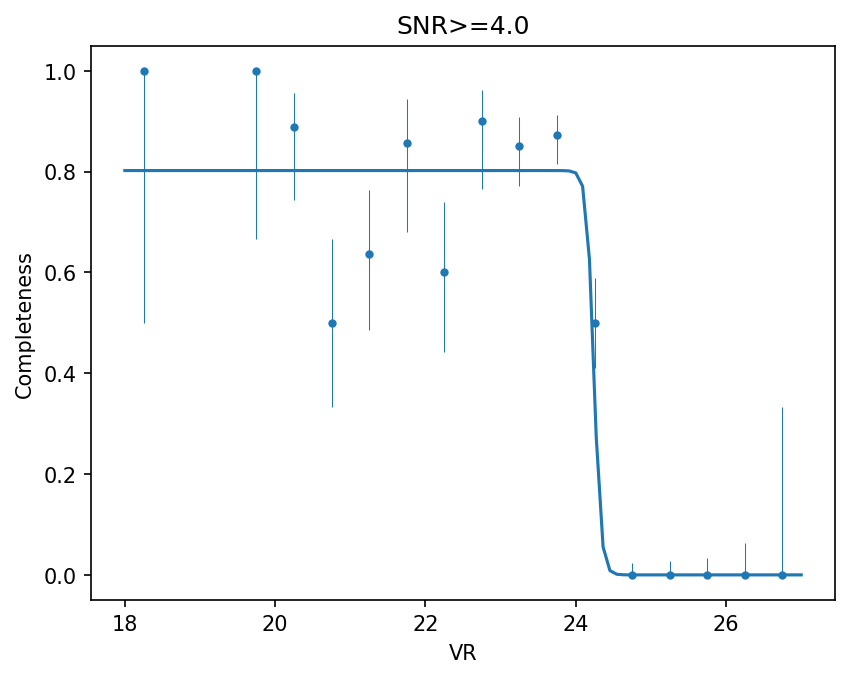

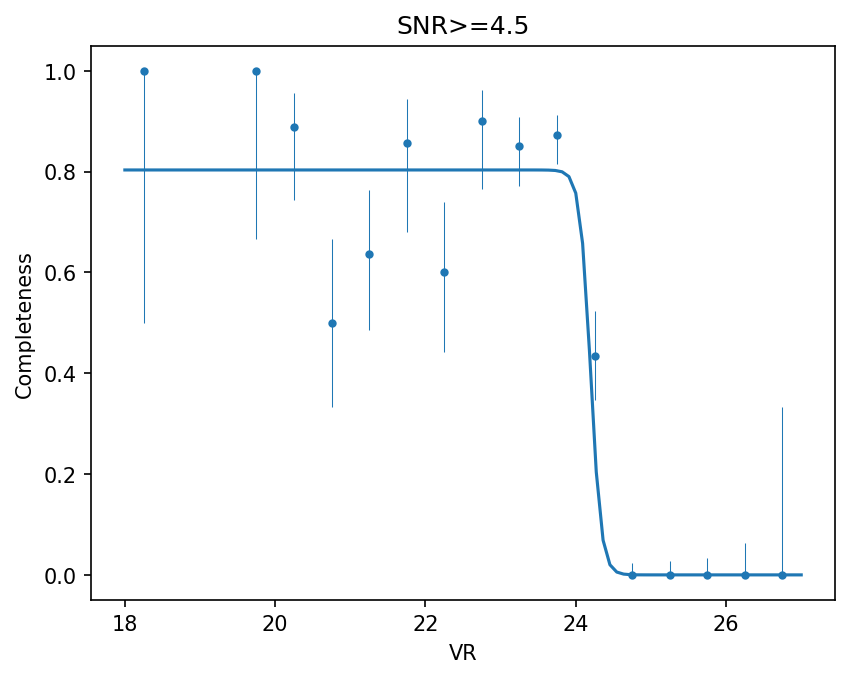

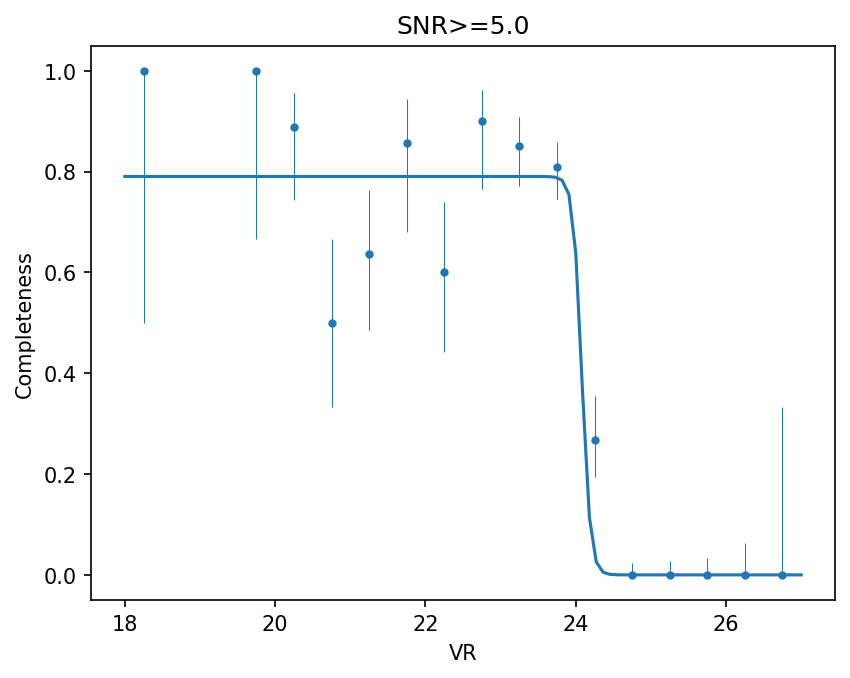

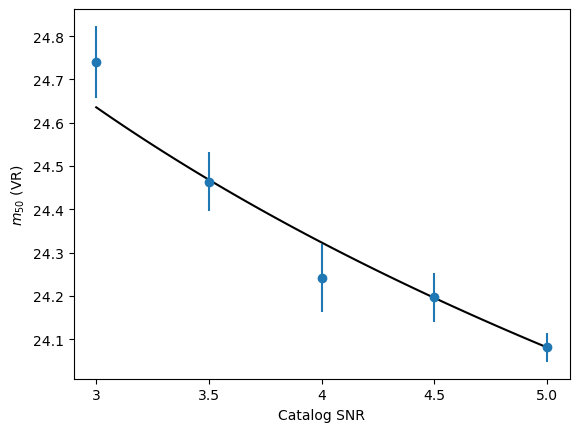

In [79]:
snrs = [3.0, 3.5, 4.0, 4.5, 5.0]
m_50 = []

sigma_m_50 = []
for snr in snrs:
    t = fit_data[snr]
    _t = t[t['in_search']]

    fit_result = do_fit(_t, found_col='found_points')
    _x = np.linspace(18, 27, 100)
    x, y, yerr = bin_detection(_t, _x.min(), _x.max(), dm=0.5, found_col='found_points')
    _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    m_50.append(fit_result['m_50'])
    sigma_m_50.append(fit_result['sigma_m_50'])
    
    plt.figure(dpi=150)
    plt.plot(_x, _y, label=f'SNR>={snr}', color=f'C0')
    plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C0")
    plt.ylabel("Completeness")
    plt.xlabel("VR")
    plt.title(f"SNR>={snr}")
    plt.show()
    
x = snrs
y = m_50
yerr = sigma_m_50
_x = np.linspace(min(x), max(x), 100)
_y = -(5/2) * np.log10(_x / max(x)) + y[x.index(5.0)]
plt.plot(_x, _y, color='k', label="expected")

plt.errorbar(snrs, y, yerr=yerr, fmt='o', label='observed')
plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
plt.xlabel("Catalog SNR")
plt.ylabel("$m_{50}$ (VR)")
plt.legend()
plt.show()

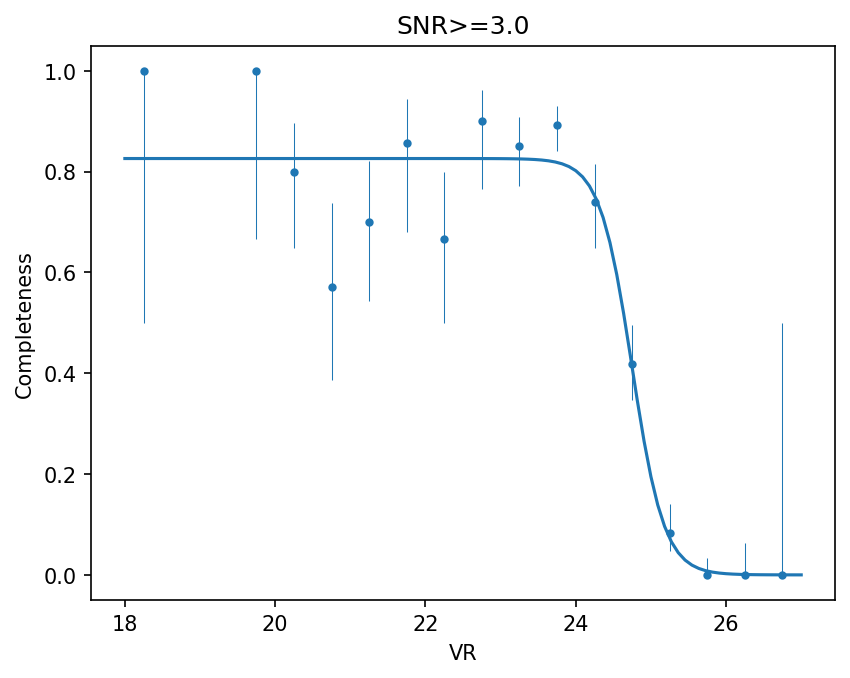

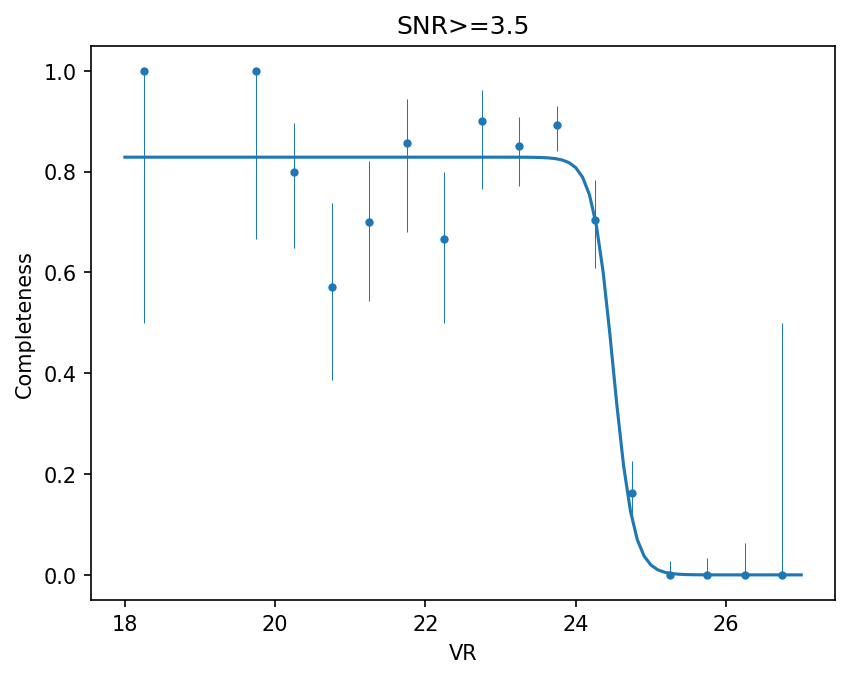

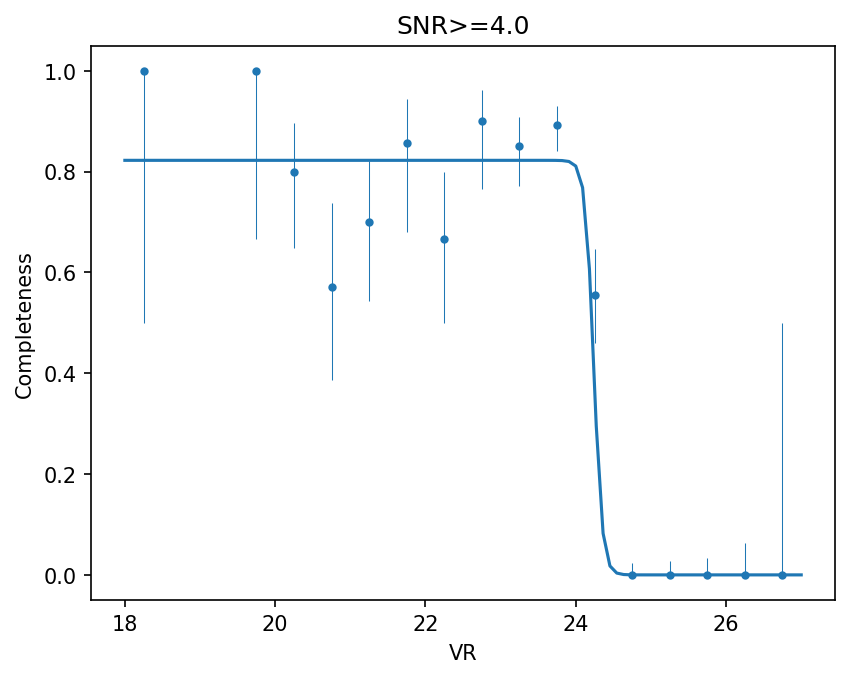

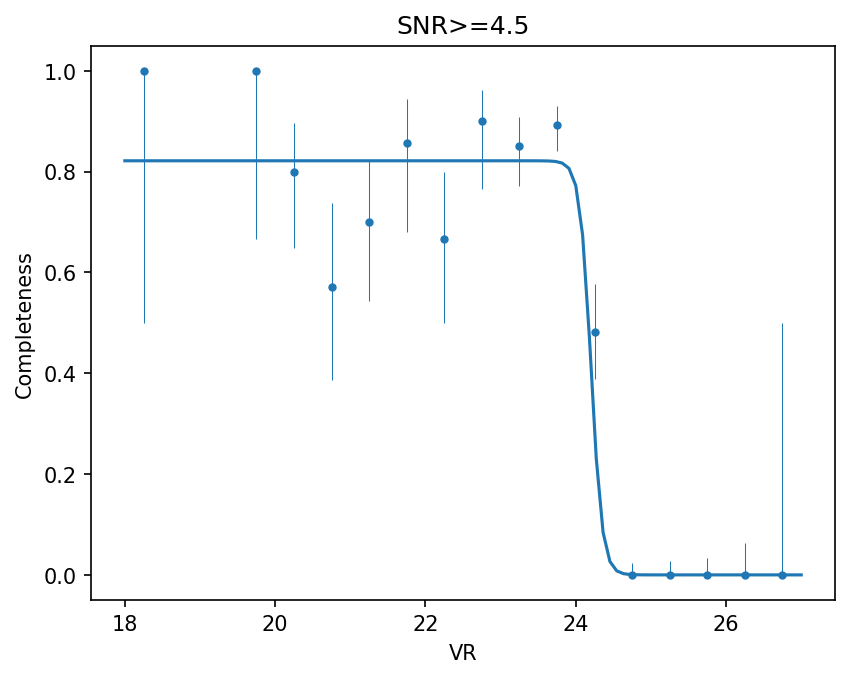

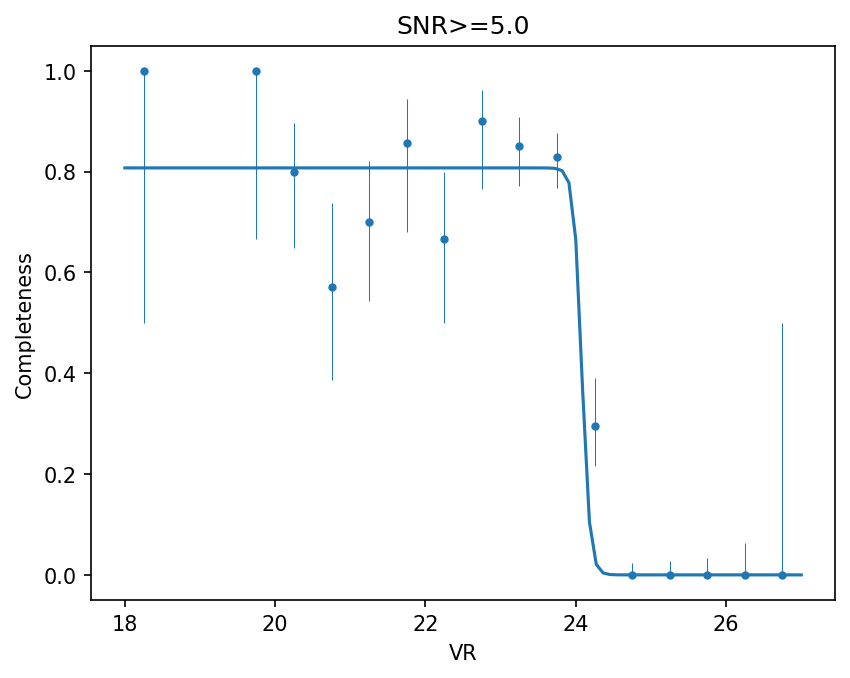

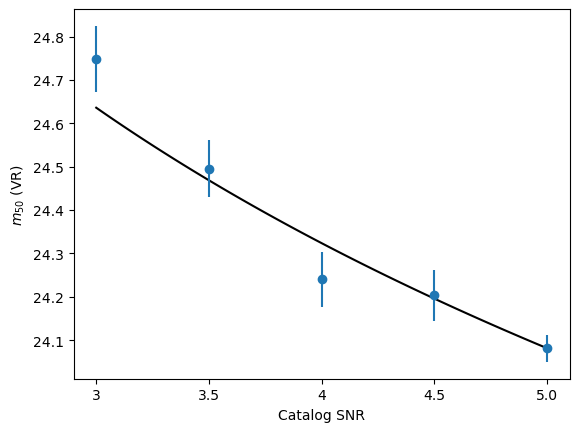

In [38]:
snrs = [3.0, 3.5, 4.0, 4.5, 5.0]
m_50 = []
sigma_m_50 = []
for snr in snrs:
    t = fit_data[snr]
    _t = t[t['in_search'] & ~t['filtered']]

    fit_result = do_fit(_t, found_col='found_points')
    _x = np.linspace(18, 27, 100)
    x, y, yerr = bin_detection(_t, _x.min(), _x.max(), dm=0.5, found_col='found_points')
    _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    m_50.append(fit_result['m_50'])
    sigma_m_50.append(fit_result['sigma_m_50'])
    
    plt.figure(dpi=150)
    plt.plot(_x, _y, label=f'SNR>={snr}', color=f'C0')
    plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C0")
    plt.ylabel("Completeness")
    plt.xlabel("VR")
    plt.title(f"SNR>={snr}")
    plt.show()
    
x = snrs
y = m_50
yerr = sigma_m_50
_x = np.linspace(min(x), max(x), 100)
_y = -(5/2) * np.log10(_x / max(x)) + y[x.index(5.0)]
plt.plot(_x, _y, color='k', label="expected")

plt.errorbar(snrs, y, yerr=yerr, fmt='o')
plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
plt.xlabel("Catalog SNR")
plt.ylabel("$m_{50}$ (VR)")
plt.show()

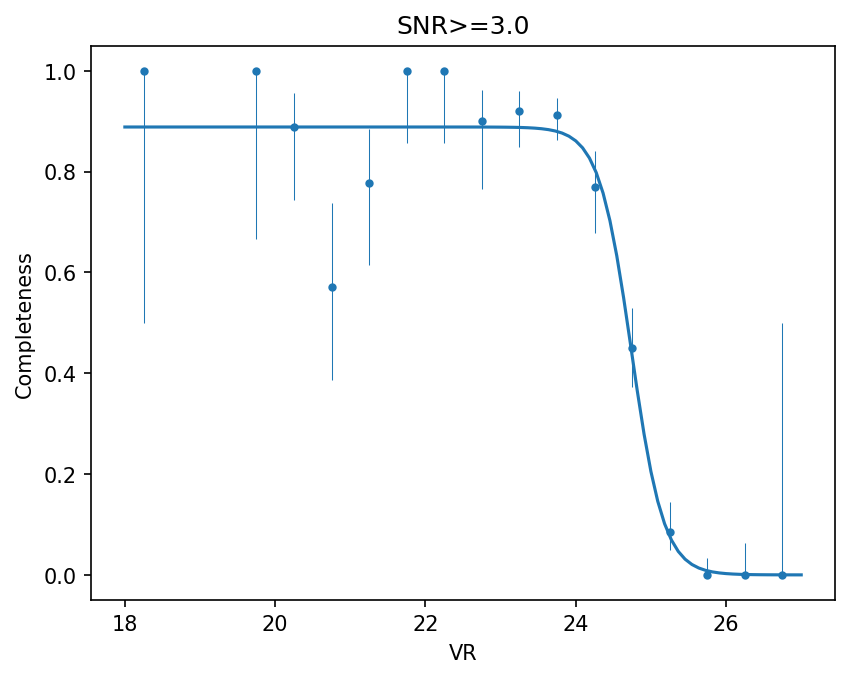

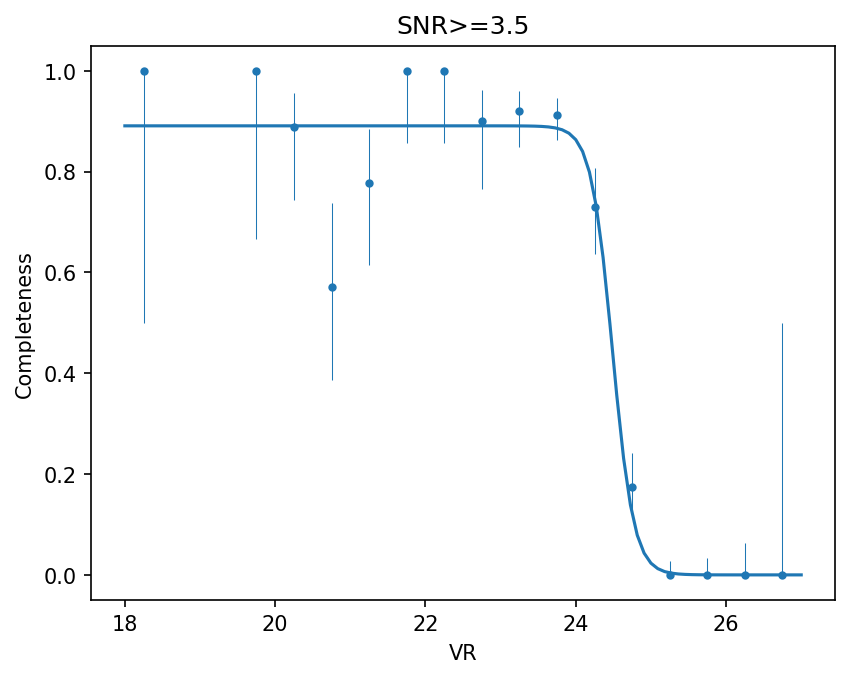

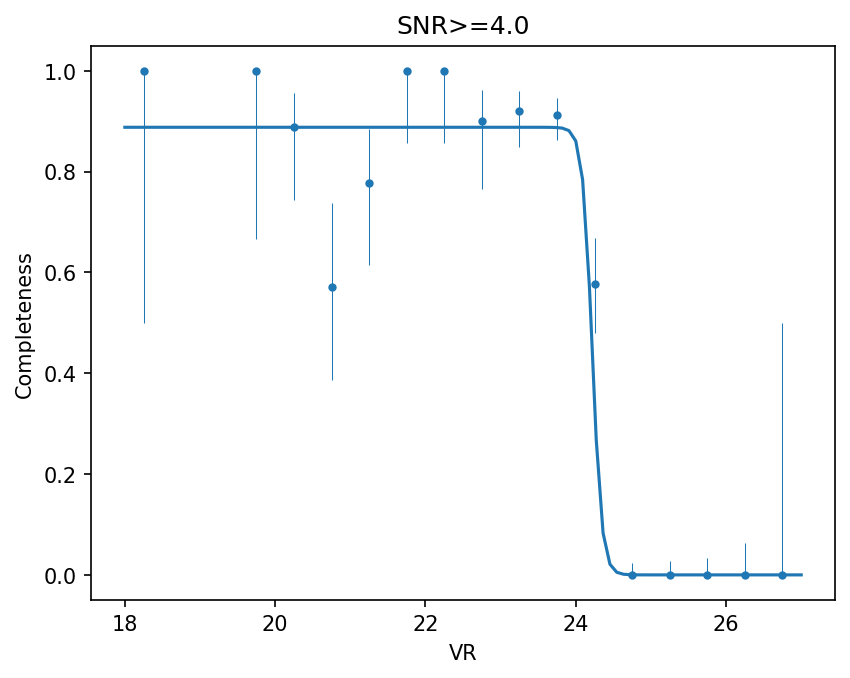

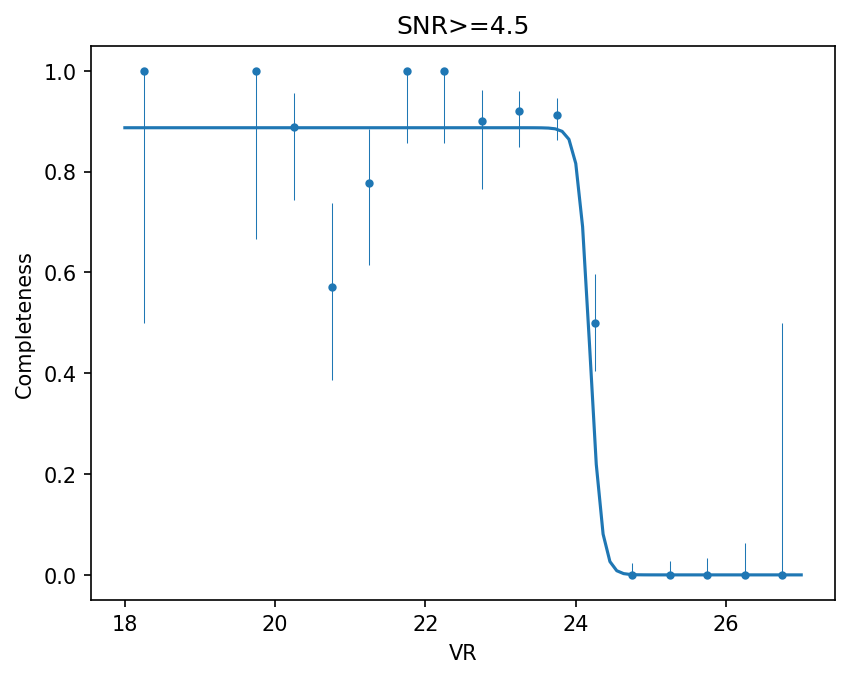

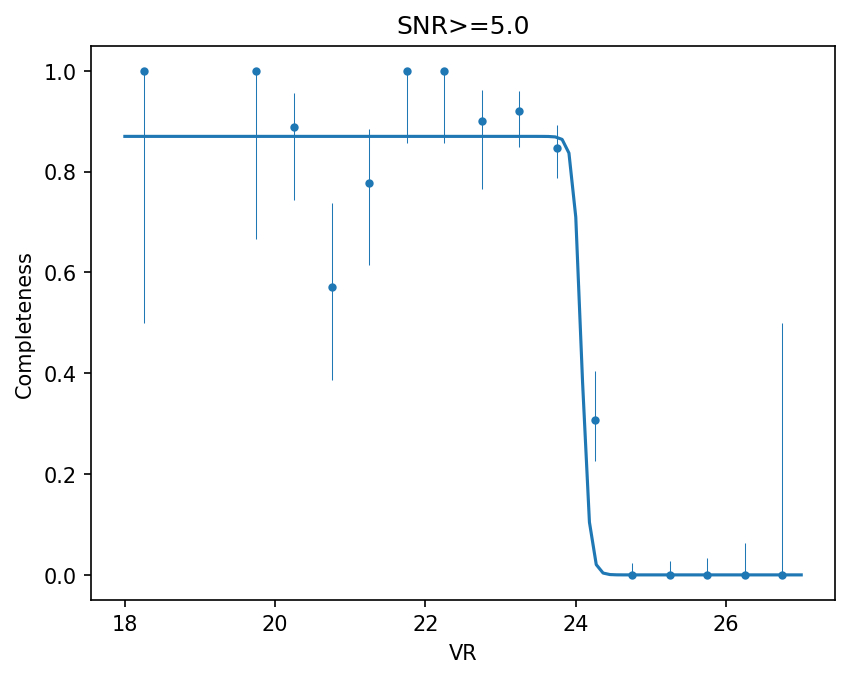

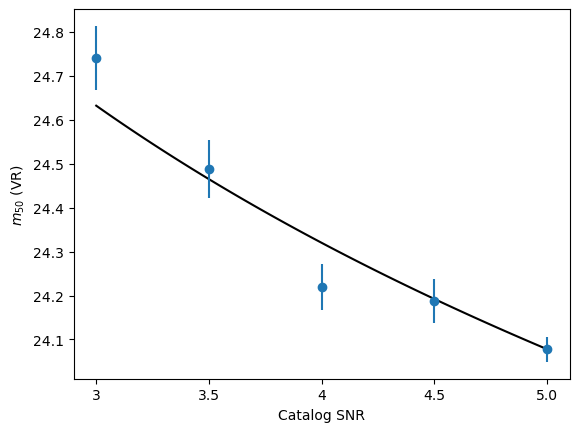

In [37]:
snrs = [3.0, 3.5, 4.0, 4.5, 5.0]
m_50 = []
sigma_m_50 = []
for snr in snrs:
    t = fit_data[snr]
    _t = t[t['in_search'] & ~t['filtered'] & (t['fake_injection'] > 15)]

    fit_result = do_fit(_t, found_col='found_points')
    _x = np.linspace(18, 27, 100)
    x, y, yerr = bin_detection(_t, _x.min(), _x.max(), dm=0.5, found_col='found_points')
    _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    m_50.append(fit_result['m_50'])
    sigma_m_50.append(fit_result['sigma_m_50'])
    
    plt.figure(dpi=150)
    plt.plot(_x, _y, label=f'SNR>={snr}', color=f'C0')
    plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C0")
    plt.ylabel("Completeness")
    plt.xlabel("VR")
    plt.title(f"SNR>={snr}")
    plt.show()
    
x = snrs
y = m_50
yerr = sigma_m_50
_x = np.linspace(min(x), max(x), 100)
_y = -(5/2) * np.log10(_x / max(x)) + y[x.index(5.0)]
plt.plot(_x, _y, color='k', label="expected")

plt.errorbar(snrs, y, yerr=yerr, fmt='o')
plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
plt.xlabel("Catalog SNR")
plt.ylabel("$m_{50}$ (VR)")
plt.show()

In [ ]:
# luminosity function for asteroids
# p(detect | mag)
# p(m) ~ 10^(\alpha m)
# N = \int dm p(m) p(s|m)
# N / N_SNR~5 vs S/N
# compare to how many I actually find at SNR

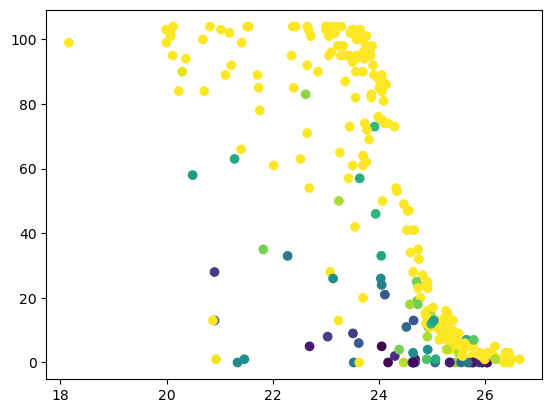

In [80]:
t = fit_data[3.0]
_t = t[filters[-1](t)]

plt.scatter(_t['mag'], _t['fake_detection'], c=_t['fake_injection'])
plt.show()

In [81]:
__t = _t[_t['mag'] < 24]
1 - __t['fake_detection'].sum() / __t['fake_injection'].sum()

0.20376965169808048

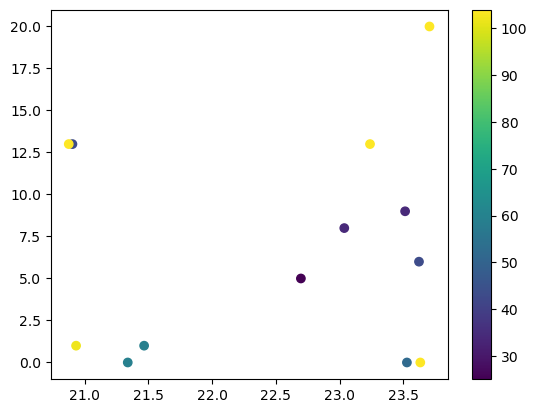

In [82]:
___t = __t[__t['fake_detection'] < 25]
plt.scatter(___t['mag'], ___t['fake_detection'], c=___t['fake_injection'])
plt.colorbar()
plt.show()

In [85]:
___t

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,bool,int64,float64
10580828,False,False,5,0,0,5,25,False,True,21,22.695686257748125
10976743,False,False,1,0,0,1,59,False,True,41,21.465905811344204
11394078,False,False,8,0,0,8,34,False,True,16,23.035964826160424
11414012,False,False,6,0,0,6,43,False,True,9,23.622005927008008
11565792,False,False,13,0,0,13,43,False,True,33,20.903537576603746
11943283,False,False,0,0,0,0,52,False,True,24,23.52727354976112
12342968,False,False,9,0,0,9,34,False,True,49,23.513127365337056
12420871,False,False,13,0,0,13,104,False,True,42,20.874750422830864
12698322,False,False,0,0,0,0,104,False,True,10,23.632323919153926


In [84]:
" ".join(map(str, ___t['orbit']))

'10580828 10976743 11394078 11414012 11565792 11943283 12342968 12420871 12698322 14180967 14306099 14540056 14774141'